In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, Flatten, Dropout

In [2]:
df = pd.read_csv('Twitter Stock Market Dataset.csv', parse_dates=['Date'], index_col=['Date'])

In [3]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-11-07,45.099998,50.090000,44.000000,44.900002,44.900002,117701670.0
2013-11-08,45.930000,46.939999,40.685001,41.650002,41.650002,27925307.0
2013-11-11,40.500000,43.000000,39.400002,42.900002,42.900002,16113941.0
2013-11-12,43.660000,43.779999,41.830002,41.900002,41.900002,6316755.0
2013-11-13,41.029999,42.869999,40.759998,42.599998,42.599998,8688325.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2264 entries, 2013-11-07 to 2022-11-03
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2259 non-null   float64
 1   High       2259 non-null   float64
 2   Low        2259 non-null   float64
 3   Close      2259 non-null   float64
 4   Adj Close  2259 non-null   float64
 5   Volume     2259 non-null   float64
dtypes: float64(6)
memory usage: 123.8 KB


In [5]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

In [6]:
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size, 3])  # Predicting 'Close' price
    return np.array(X), np.array(y)

In [7]:
train_size = int(len(df) * 0.9)
validation_size = int(train_size * 0.05)
test_size = int(train_size * 0.05)

train_data = scaled_data[:train_size]
val_data = scaled_data[train_size:train_size + validation_size]
test_data = scaled_data[train_size + validation_size:train_size + validation_size + test_size]

In [8]:
window_size = 10

X_train, y_train = create_sequences(train_data, window_size)
X_val, y_val = create_sequences(val_data, window_size)
X_test, y_test = create_sequences(test_data, window_size)

In [9]:
input_layer = Input(shape=(window_size, 6))

conv1 = Conv1D(filters=64, kernel_size=2, activation='relu')(input_layer)
conv2 = Conv1D(filters=128, kernel_size=2, activation='relu')(conv1)
flatten = Flatten()(conv2)

lstm = LSTM(64, return_sequences=False)(input_layer)

merged = tf.keras.layers.concatenate([flatten, lstm])

dense1 = Dense(64, activation='relu')(merged)
dropout = Dropout(0.2)(dense1)
output_layer = Dense(1, activation='linear')(dropout)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [10]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/50
64/64 [==============================] - 10s 42ms/step - loss: 0.0918 - mae: 0.1986 - val_loss: 0.0426 - val_mae: 0.1466
Epoch 2/50
64/64 [==============================] - 1s 18ms/step - loss: 0.0407 - mae: 0.1424 - val_loss: 0.0478 - val_mae: 0.1531
Epoch 3/50
64/64 [==============================] - 1s 19ms/step - loss: 0.0360 - mae: 0.1340 - val_loss: 0.0423 - val_mae: 0.1391
Epoch 4/50
64/64 [==============================] - 1s 19ms/step - loss: 0.0350 - mae: 0.1310 - val_loss: 0.0287 - val_mae: 0.1236
Epoch 5/50
64/64 [==============================] - 1s 19ms/step - loss: 0.0327 - mae: 0.1267 - val_loss: 0.0271 - val_mae: 0.1119
Epoch 6/50
64/64 [==============================] - 1s 17ms/step - loss: 0.0287 - mae: 0.1187 - val_loss: 0.0212 - val_mae: 0.0998
Epoch 7/50
64/64 [==============================] - 1s 19ms/step - loss: 0.0271 - mae: 0.1171 - val_loss: 0.0366 - val_mae: 0.1321
Epoch 8/50
64/64 [==============================] - 1s 19ms/step - loss: 0.0253 - 

In [11]:
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

3/3 [==============================] - 0s 12ms/step - loss: 0.0114 - mae: 0.0833
Test Loss: 0.011421168223023415, Test MAE: 0.08331968635320663


In [12]:
predictions = model.predict(X_test)

y_test_actual = scaler.inverse_transform(np.hstack((np.zeros((y_test.shape[0], 5)), y_test.reshape(-1, 1))))[:, -1]
predictions_actual = scaler.inverse_transform(np.hstack((np.zeros((predictions.shape[0], 5)), predictions)))[:, -1]

3/3 [==============================] - 1s 9ms/step


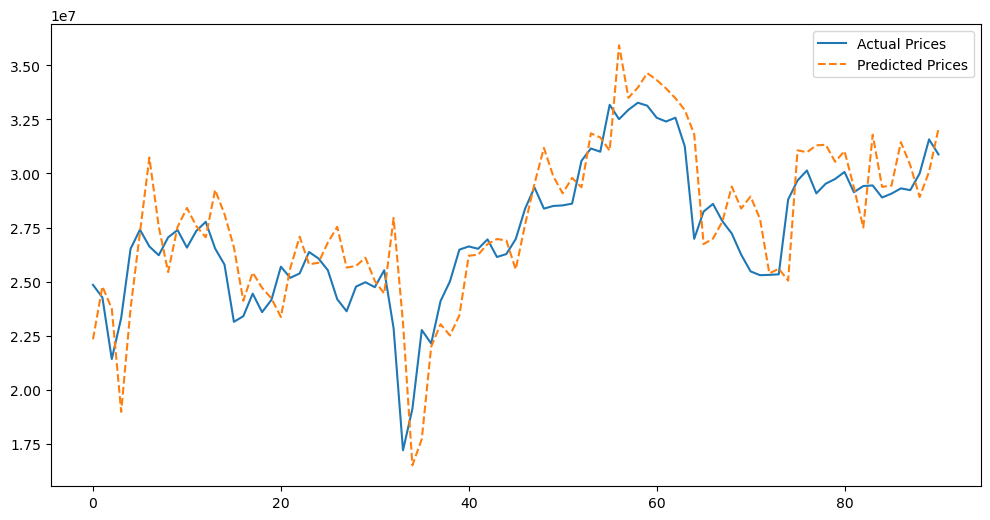

In [13]:
plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label="Actual Prices")
plt.plot(predictions_actual, label="Predicted Prices", linestyle="dashed")
plt.legend()
plt.show()